# intro

test fitting 'strain' ringdown with multiple modes
and fitting amp and freq around the peak -/+ 10-30M

In [217]:
import qnm

# qnm.download_data()

In [218]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [219]:
import re
import glob
import os
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import numpy as np
import pandas as pd
import pathlib

In [220]:
import nr_utils

In [221]:
import lmfit

In [222]:
import scipy.optimize

In [223]:
import phenom

In [224]:
### Need to modify this by the energy radiated as qnm assumes total mass of 1M i guess
def get_angular_ringdown_frequency_from_bbh(q, l, m, n=0):
    eta = phenom.eta_from_q(q)
    remnant_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    e_rad = phenom.remnant.EradRational0815(eta, 0, 0)

    mc = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, _, _ = mc(a=remnant_spin)
    return np.real(omega) / (1 - e_rad)
    
def get_angular_damping_frequency_from_bbh(q, l, m, n=0):
    eta = phenom.eta_from_q(q)
    remnant_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    e_rad = phenom.remnant.EradRational0815(eta, 0, 0)

    mc = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, _, _ = mc(a=remnant_spin)
    return -np.imag(omega) / (1 - e_rad)

In [225]:
get_angular_ringdown_frequency_from_bbh(1, 2, 2)

0.5534656465229616

In [226]:
get_angular_damping_frequency_from_bbh(1, 2, 2)

0.08542339187414541

In [227]:
phenom.remnant.FinalSpin0815(0.25, 0, 0)

0.6864170524001022

In [228]:
phenom.fring(0.25, 0, 0, 0.68)*2*np.pi

0.5506181900334295

In [229]:
phenom.fdamp(0.25, 0, 0, 0.68)*2*np.pi

0.08565716198829981

In [230]:
# sxs_list=[
#     # '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5',
#     # '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res3.h5'
#     '/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5',
# ]


In [231]:
    
#     "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5", #q=2
#     "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5", #q=10


In [232]:
lms = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5),(5,4)]

In [233]:
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10
simname = nrfile.split('/')[-1].split('.h5')[0]
nrls = {}
for l, m in lms:
    nrls[l,m] = nr_utils.NRLoader(handler='nr_hdf5', nr_hdf5_filename=nrfile, dt=0.1, safety_factor=0.5, ell=l, mm=m)

In [234]:
nrls[(2,2)].q

4.999987992047933

In [235]:
nrls.keys()

dict_keys([(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3), (5, 5), (5, 4)])

In [236]:
nrls[2,1].times

array([-7466.35923209, -7466.25923209, -7466.15923209, ...,
         450.44076794,   450.54076794,   450.64076794])

In [237]:
nrls[2,1].strain

array([-2.17300915e-03-2.31582102e-03j, -2.16929011e-03-2.31926412e-03j,
       -2.16556709e-03-2.32270650e-03j, ...,
       -6.58650588e-07-1.78944408e-07j, -6.58457195e-07-1.75672074e-07j,
       -6.58267795e-07-1.72341229e-07j])

(-100.0, 100.0)

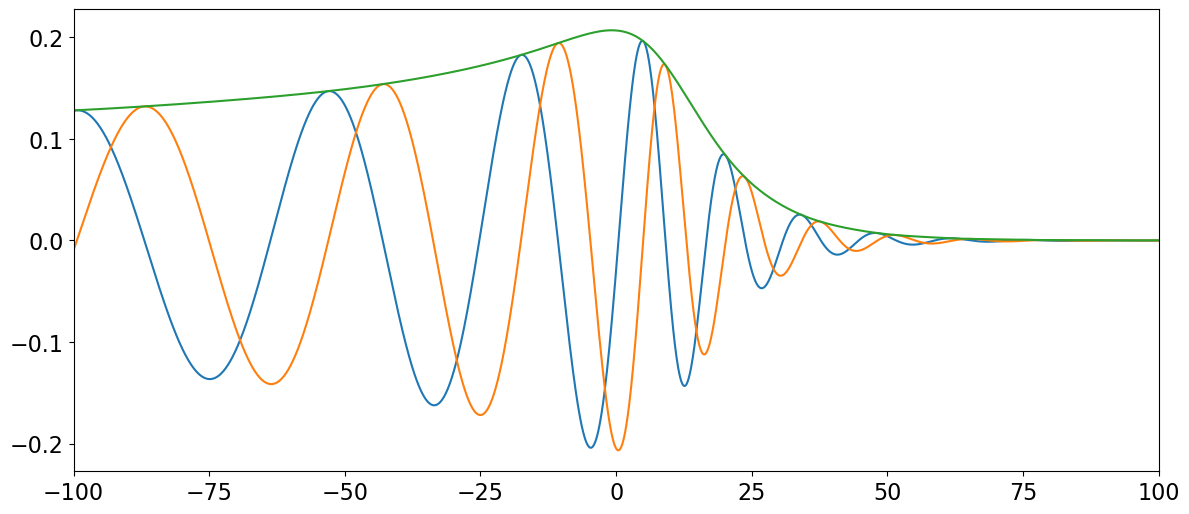

In [238]:
plt.figure(figsize=(14,6))
plt.plot(nrls[2,2].times, nrls[2,2].strain.real)
plt.plot(nrls[2,2].times, nrls[2,2].strain.imag)
plt.plot(nrls[2,2].times, np.abs(nrls[2,2].strain))
plt.xlim(-100,100)

(-100.0, 100.0)

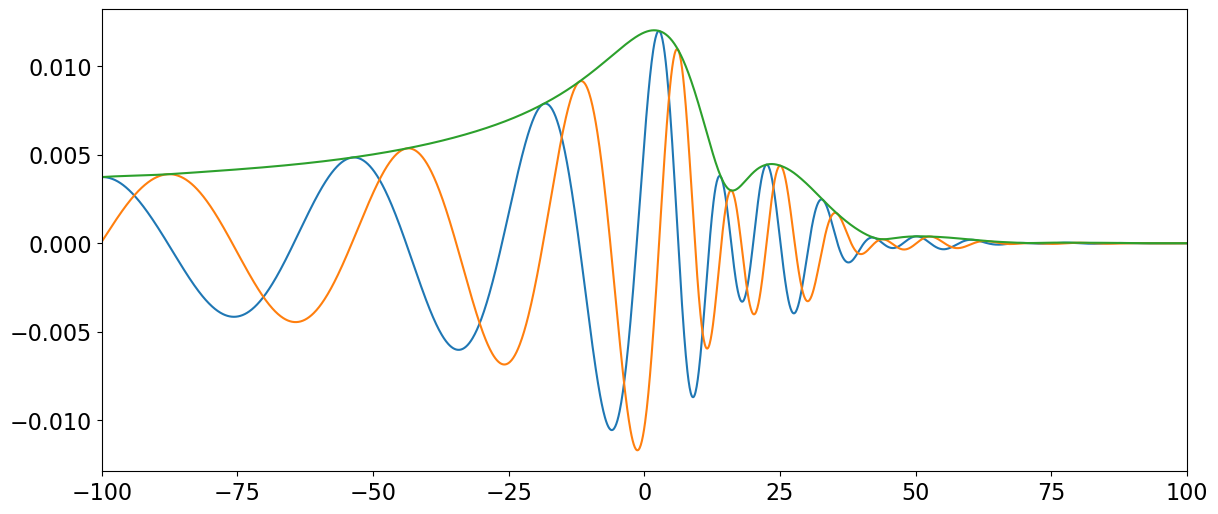

In [239]:
plt.figure(figsize=(14,6))
plt.plot(nrls[3,2].times, nrls[3,2].strain.real)
plt.plot(nrls[3,2].times, nrls[3,2].strain.imag)
plt.plot(nrls[3,2].times, np.abs(nrls[3,2].strain))
plt.xlim(-100,100)

# modelling

In [240]:
def ringdown_strain(x, t0, phi0, amp, omega, decay, sinusoid_fn=np.cos):
    """
    sinusoid_fn: either np.cos or np.sin depending on if you are fitting the real or imag part
    """
    return amp * np.exp(-(x-t0)/decay) * sinusoid_fn(x*omega + phi0)

In [241]:
model_ringdown_strain = lmfit.Model(ringdown_strain)
                                    # prefix='_22_')

In [242]:
model_ringdown_strain.independent_vars

['x']

In [243]:
model_ringdown_strain.param_names

['t0', 'phi0', 'amp', 'omega', 'decay']

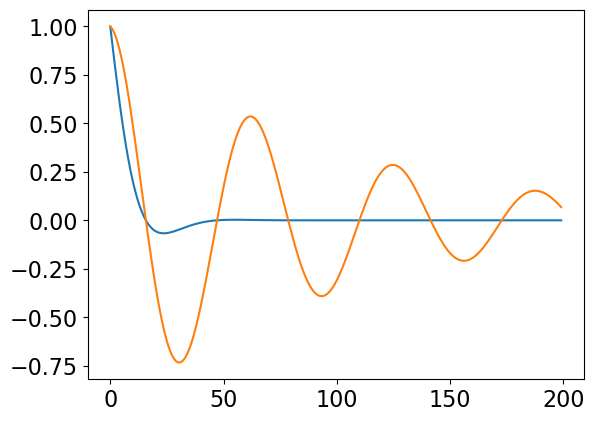

In [244]:
plt.plot(model_ringdown_strain.eval(x=np.arange(0, 20, 0.1), t0=0, phi0=0, amp=1, omega=1, decay=1))
plt.plot(model_ringdown_strain.eval(x=np.arange(0, 20, 0.1), t0=0, phi0=0, amp=1, omega=1, decay=10))

In [245]:
q = nrls[(2,2)].q
q

4.999987992047933

In [246]:
x = nrls[2,2].times
y = nrls[2,2].strain.real

start_time = 10
end_time = 80

mask = np.where((x >= start_time) & (x <= end_time))
x=x[mask]
y=y[mask]

amp0 = float(IUS(x, np.abs(nrls[2,2].strain)[mask])(start_time))
amp0

0.16591054113376738

In [247]:
params = model_ringdown_strain.make_params(
    t0=dict(value=start_time, vary=False),
    phi0=dict(value=0.5, min=-2*np.pi, max=2*np.pi),
    amp=dict(value=amp0, min=0, vary=False),
    omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,2,2), vary=False),
    decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 2, 2), vary=False)
)

In [248]:
fr = model_ringdown_strain.fit(y, params, x=x, )

In [249]:
fr.params

Parameters([('t0', <Parameter 't0', value=10 (fixed), bounds=[-inf:inf]>), ('phi0', <Parameter 'phi0', value=-2.741537708992843 +/- 0.00764, bounds=[-6.283185307179586:6.283185307179586]>), ('amp', <Parameter 'amp', value=0.16591054113376738 (fixed), bounds=[0:inf]>), ('omega', <Parameter 'omega', value=0.45151998117484393 (fixed), bounds=[-inf:inf]>), ('decay', <Parameter 'decay', value=11.329310677899834 (fixed), bounds=[-inf:inf]>)])

<Axes: title={'center': 'Model(ringdown_strain)'}, xlabel='x', ylabel='y'>

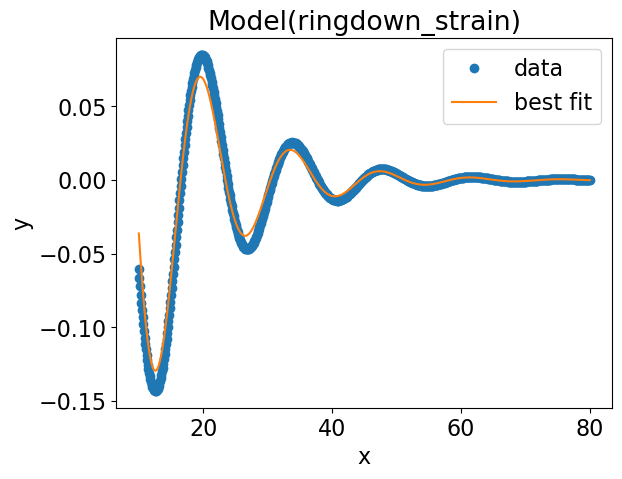

In [250]:
fr.plot_fit()

<Axes: title={'center': 'Model(ringdown_strain)'}, ylabel='residuals'>

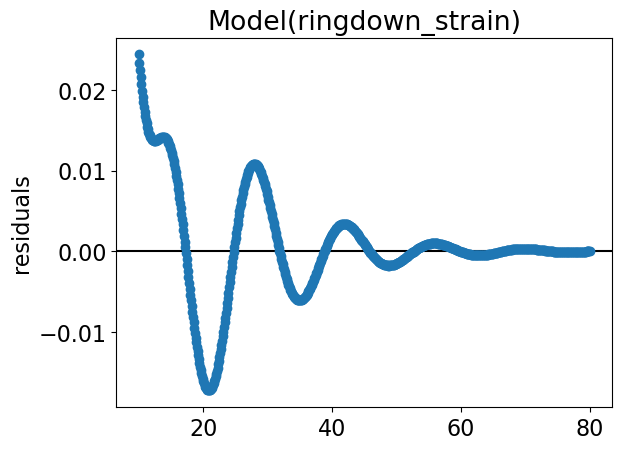

In [251]:
fr.plot_residuals()

In [252]:
model_ringdown_strain_32 = (
    lmfit.Model(ringdown_strain, prefix='_22_')
    + lmfit.Model(ringdown_strain, prefix='_32_')
    + lmfit.Model(ringdown_strain, prefix='_221_')
    + lmfit.Model(ringdown_strain, prefix='_321_')
)

In [253]:
model_ringdown_strain_32

<lmfit.Model: (((Model(ringdown_strain, prefix='_22_') + Model(ringdown_strain, prefix='_32_')) + Model(ringdown_strain, prefix='_221_')) + Model(ringdown_strain, prefix='_321_'))>

In [254]:
x = nrls[3,2].times
y = nrls[3,2].strain.real

start_time = 10
end_time = 90

mask = np.where((x >= start_time) & (x <= end_time))
x=x[mask]
y=y[mask]

amp0 = np.abs(nrls[3,2].strain)[mask][0]

In [255]:
# strategy to fit the data is to let all / most parameters be free to find phi0 best values
# then re-fit with RD freq and damp fixed?

In [256]:
params = model_ringdown_strain_32.make_params(
    # 22
    _22_t0=dict(value=start_time, min=-10, vary=False),
    _22_phi0=dict(value=np.random.uniform(-1, 1), min=-2*np.pi, max=2*np.pi),
    _22_amp=dict(value=amp0, min=0),
    _22_omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,2,2), vary=False),
    _22_decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 2, 2), vary=False),
    # 32
    _32_t0=dict(value=start_time, min=-10, vary=False),
    _32_phi0=dict(value=np.random.uniform(-1, 1), min=-2*np.pi, max=2*np.pi),
    _32_amp=dict(value=amp0/2, min=0),
    _32_omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,3,2), vary=False),
    _32_decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 3, 2), vary=False),
    # 221
    _221_t0=dict(value=start_time, min=-10, vary=False),
    _221_phi0=dict(value=np.random.uniform(-1, 1), min=-2*np.pi, max=2*np.pi),
    _221_amp=dict(value=amp0, min=0),
    _221_omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,2,2,1), vary=False),
    _221_decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 2, 2,1), vary=False),
    # 321
    _321_t0=dict(value=start_time, min=-10, vary=False),
    _321_phi0=dict(value=np.random.uniform(-1, 1), min=-2*np.pi, max=2*np.pi),
    _321_amp=dict(value=amp0, min=0),
    _321_omega=dict(value=get_angular_ringdown_frequency_from_bbh(q,3,2,1), vary=False),
    _321_decay=dict(value=1/get_angular_damping_frequency_from_bbh(q, 3, 2,1), vary=False),
)
params

Parameters([('_22_t0', <Parameter '_22_t0', value=10 (fixed), bounds=[-10:inf]>), ('_22_phi0', <Parameter '_22_phi0', value=-0.4457630361783034, bounds=[-6.283185307179586:6.283185307179586]>), ('_22_amp', <Parameter '_22_amp', value=0.007812384546701865, bounds=[0:inf]>), ('_22_omega', <Parameter '_22_omega', value=0.45151998117484393 (fixed), bounds=[-inf:inf]>), ('_22_decay', <Parameter '_22_decay', value=11.329310677899834 (fixed), bounds=[-inf:inf]>), ('_32_t0', <Parameter '_32_t0', value=10 (fixed), bounds=[-10:inf]>), ('_32_phi0', <Parameter '_32_phi0', value=0.8215954230619174, bounds=[-6.283185307179586:6.283185307179586]>), ('_32_amp', <Parameter '_32_amp', value=0.0039061922733509323, bounds=[0:inf]>), ('_32_omega', <Parameter '_32_omega', value=0.6847901880101372 (fixed), bounds=[-inf:inf]>), ('_32_decay', <Parameter '_32_decay', value=10.862653372491124 (fixed), bounds=[-inf:inf]>), ('_221_t0', <Parameter '_221_t0', value=10 (fixed), bounds=[-10:inf]>), ('_221_phi0', <Parameter '_221_phi0', value=0.9568854423490443, bounds=[-6.283185307179586:6.283185307179586]>), ('_221_amp', <Parameter '_221_amp', value=0.007812384546701865, bounds=[0:inf]>), ('_221_omega', <Parameter '_221_omega', value=0.4325561832413331 (fixed), bounds=[-inf:inf]>), ('_221_decay', <Parameter '_221_decay', value=3.719829566895295 (fixed), bounds=[-inf:inf]>), ('_321_t0', <Parameter '_321_t0', value=10 (fixed), bounds=[-10:inf]>), ('_321_phi0', <Parameter '_321_phi0', value=-0.024871283623890683, bounds=[-6.283185307179586:6.283185307179586]>), ('_321_amp', <Parameter '_321_amp', value=0.007812384546701865, bounds=[0:inf]>), ('_321_omega', <Parameter '_321_omega', value=0.6721306189486052 (fixed), bounds=[-inf:inf]>), ('_321_decay', <Parameter '_321_decay', value=3.591712287773645 (fixed), bounds=[-inf:inf]>)])

In [257]:
fr = model_ringdown_strain_32.fit(y, params, x=x)

In [258]:
fr

<Axes: title={'center': "(((Model(ringdown_strain, prefix='_22_') + Model(ringdown_strain, prefix='_32_')) + Model(ringdown_strain, prefix='_221_')) + Model(ringdown_strain, prefix='_321_'))"}, xlabel='x', ylabel='y'>

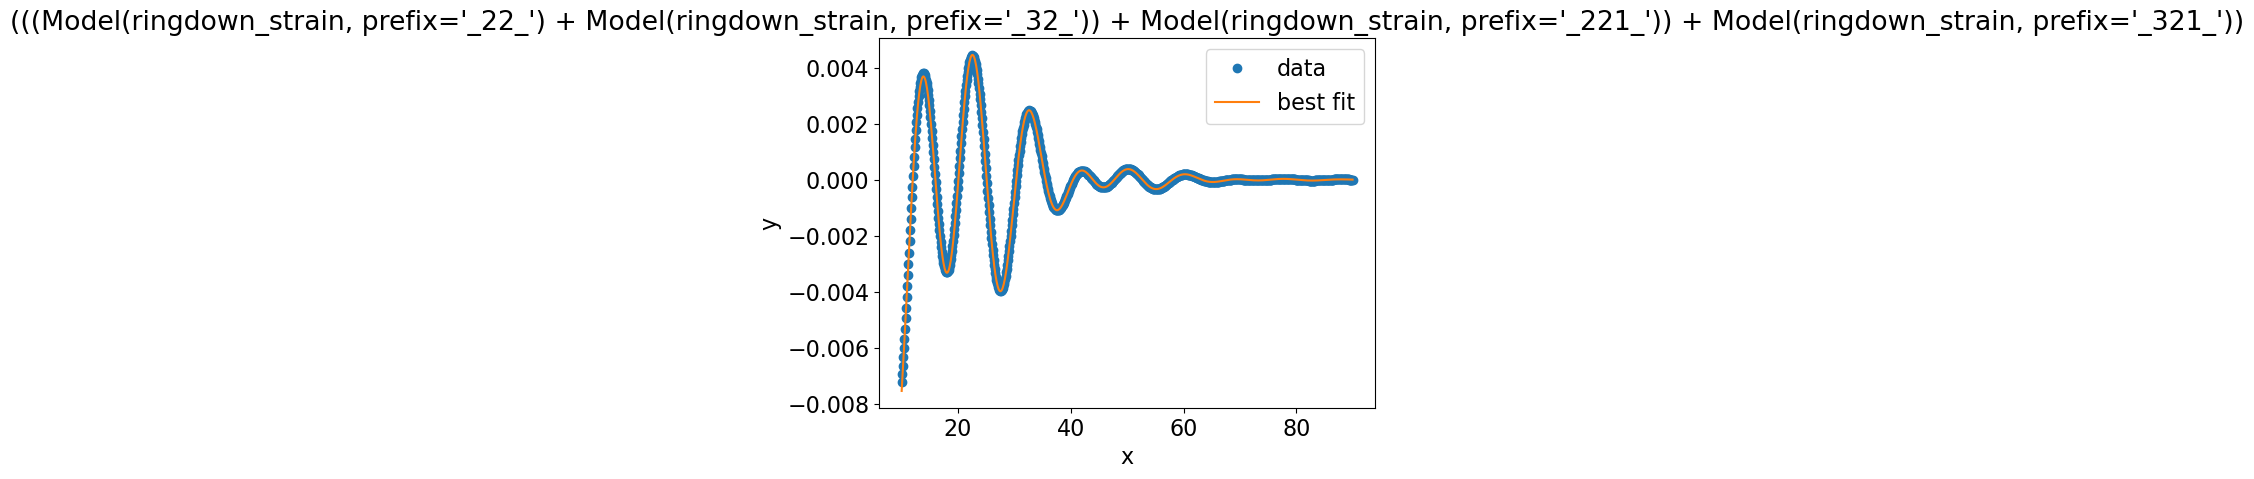

In [259]:
fr.plot_fit()

<Axes: title={'center': "(((Model(ringdown_strain, prefix='_22_') + Model(ringdown_strain, prefix='_32_')) + Model(ringdown_strain, prefix='_221_')) + Model(ringdown_strain, prefix='_321_'))"}, ylabel='residuals'>

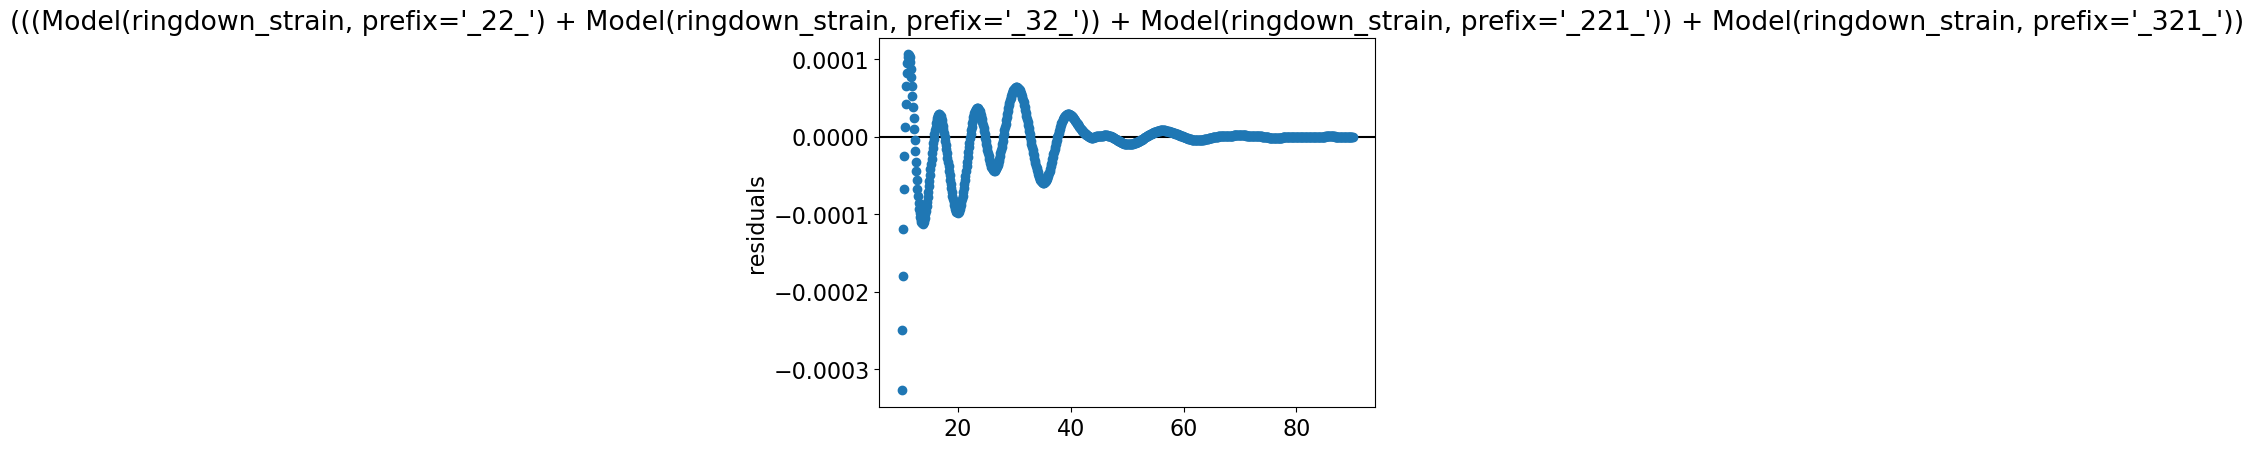

In [260]:
fr.plot_residuals()

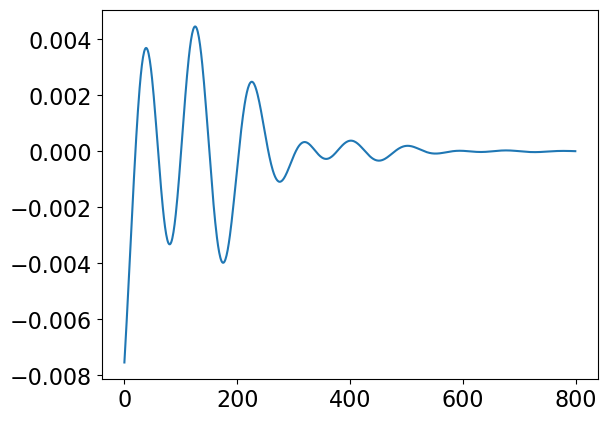

In [261]:
plt.plot(model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos))

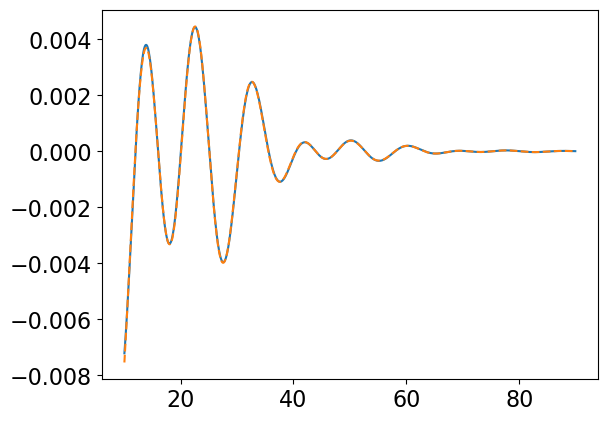

In [262]:
plt.plot(x, nrls[3,2].strain.real[mask])
# plt.plot(x, fr.eval(), ls='--')
plt.plot(x, model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos), ls='--')


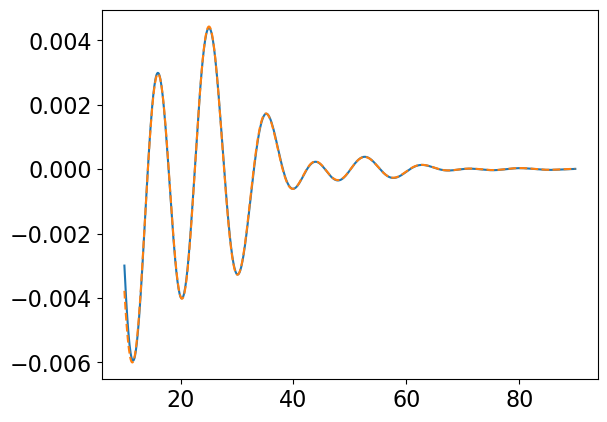

In [263]:
plt.plot(x, nrls[3,2].strain.imag[mask])
# plt.plot(x, fr.eval(sinusoid_fn=np.sin), ls='--')
plt.plot(x, model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.sin), ls='--')

In [264]:
# yhat_h = fr.eval() + 1.j * fr.eval(sinusoid_fn=np.sin)

yhat_h_re = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos)
yhat_h_im = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.sin)

yhat_h = yhat_h_re + 1.j * yhat_h_im

yhat_h_abs = np.abs(yhat_h)
yhat_h_phase = np.unwrap(np.angle(yhat_h))

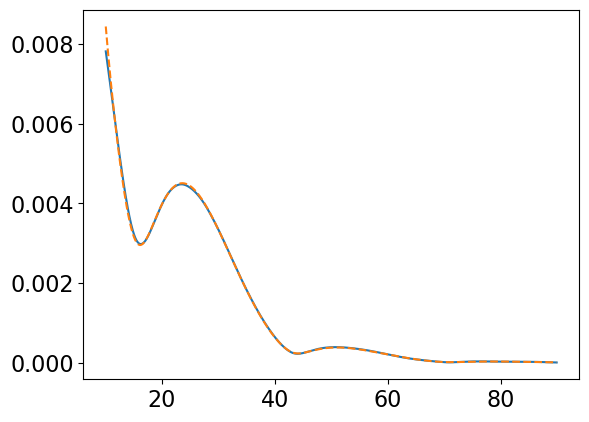

In [265]:
plt.plot(x, np.abs(nrls[3,2].strain)[mask])
plt.plot(x, yhat_h_abs, ls='--')

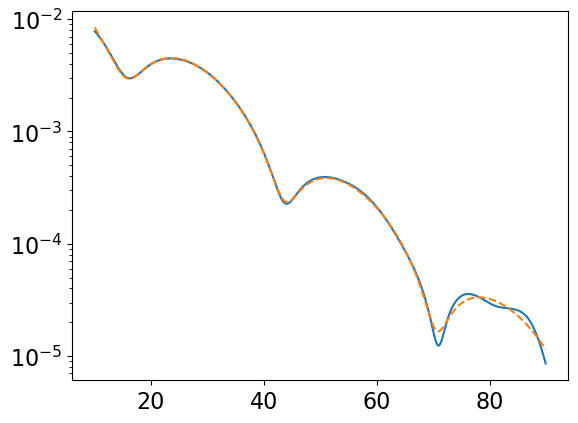

In [266]:
plt.plot(x, np.abs(nrls[3,2].strain)[mask])
plt.plot(x, yhat_h_abs, ls='--')
plt.yscale('log')

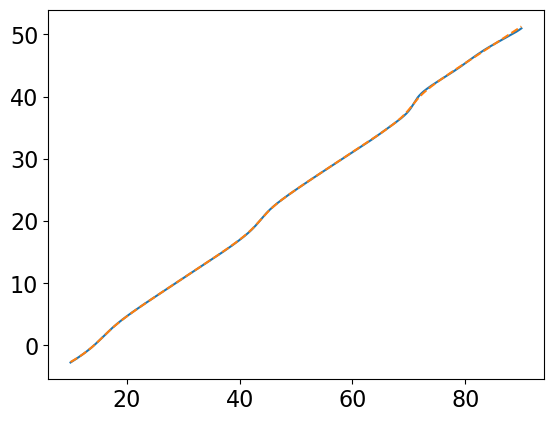

In [267]:
plt.plot(x, np.unwrap(np.angle(nrls[3,2].strain[mask])))
plt.plot(x, yhat_h_phase, ls='--')

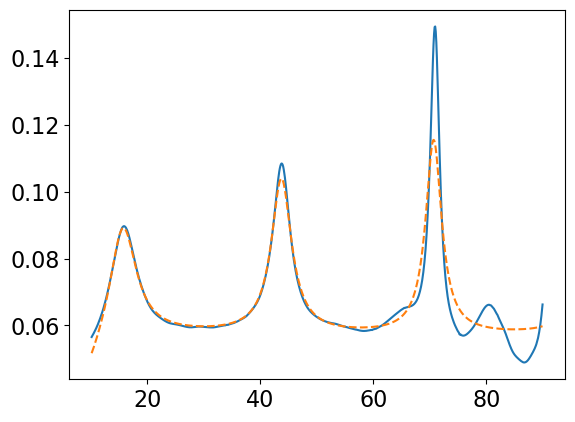

In [268]:
plt.plot(x[1:], np.diff(np.unwrap(np.angle(nrls[3,2].strain[mask]))))
plt.plot(x[1:], np.diff(yhat_h_phase), ls='--')

In [269]:
x = nrls[3,2].times
y = nrls[3,2].strain

# mask = (x > -100) & (x < 150)
mask = (x > 0) & (x < 150)
x=x[mask]
y=y[mask]


yhat_h_re = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.cos)
yhat_h_im = model_ringdown_strain_32.eval(fr.params, x=x, sinusoid_fn=np.sin)

yhat_h = yhat_h_re + 1.j * yhat_h_im

yhat_h_abs = np.abs(yhat_h)

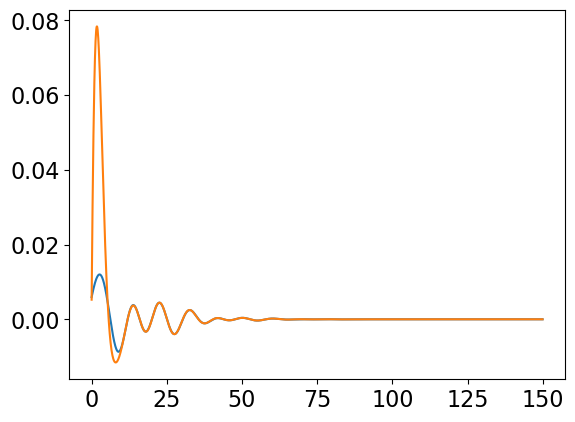

In [270]:
plt.plot(x, y.real)
plt.plot(x, yhat_h.real)

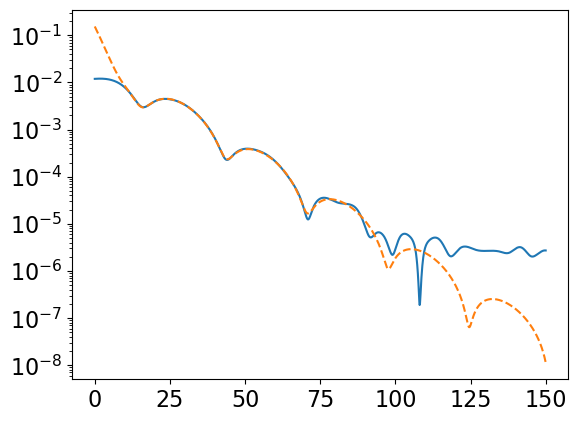

In [271]:
plt.plot(x, np.abs(y))
plt.plot(x, np.abs(yhat_h), ls='--')
plt.yscale('log')

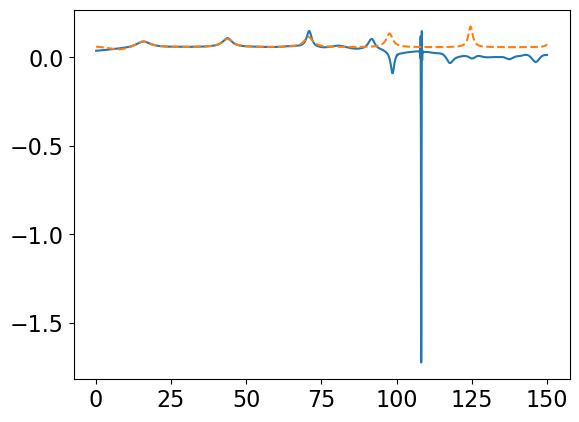

In [272]:
plt.plot(x[1:], np.diff(np.unwrap(np.angle(y))))
plt.plot(x[1:], np.diff(np.unwrap(np.angle(yhat_h))), ls='--')

(0.0, 0.14168406642343423)

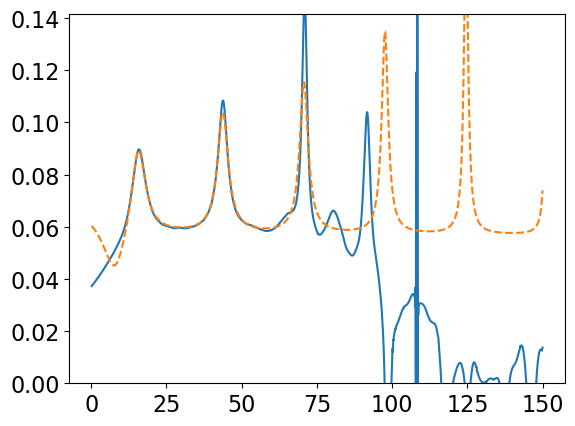

In [273]:
plt.plot(x[1:], np.diff(np.unwrap(np.angle(y))))
plt.plot(x[1:], np.diff(np.unwrap(np.angle(yhat_h))), ls='--')
plt.ylim(0, get_angular_ringdown_frequency_from_bbh(q, 3, 2)/2/np.pi * 1.3)

# try modelling around the peak

In [274]:
x = nrls[3,2].times
y_complex = nrls[3,2].strain

# start_time = -100
start_time = -200
end_time = 10

mask = np.where((x >= start_time) & (x <= end_time))
x=x[mask]
y_complex=y_complex[mask]

y_amp = np.abs(y_complex)
y_phase = np.unwrap(np.angle(y_complex))
y_freq = IUS(x, y_phase).derivative()(x)

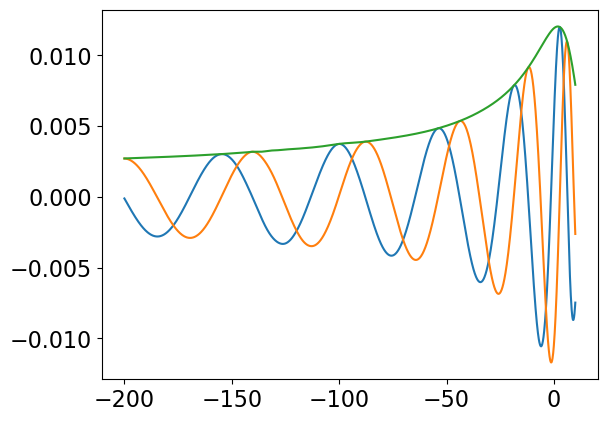

In [275]:
plt.plot(x, y_complex.real)
plt.plot(x, y_complex.imag)
plt.plot(x, y_amp)

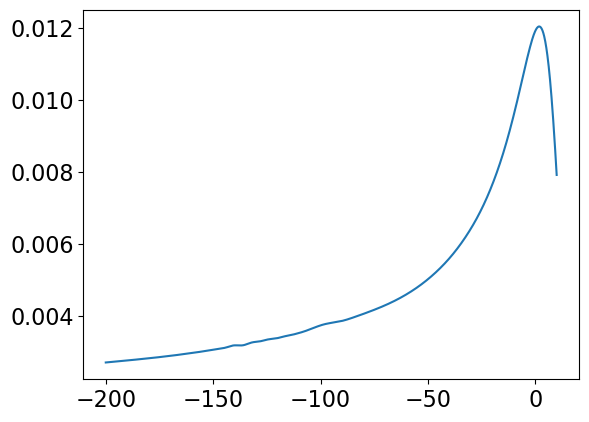

In [276]:
plt.plot(x, y_amp)

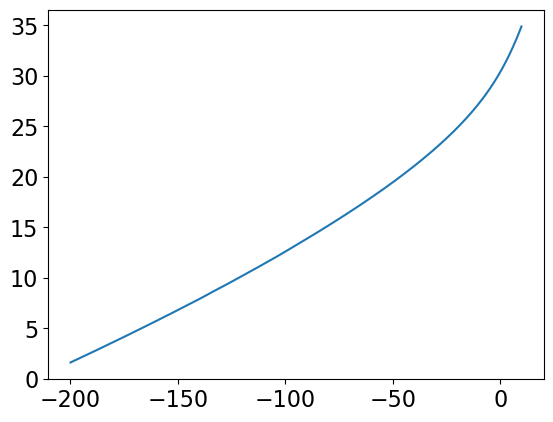

In [277]:
plt.plot(x, y_phase)

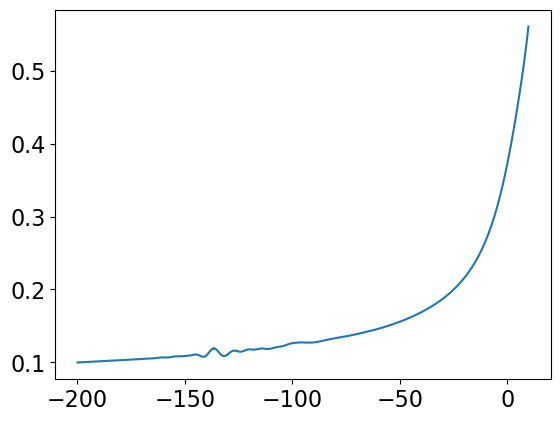

In [278]:
plt.plot(x, y_freq)

In [279]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [280]:
X_train = x[:,np.newaxis]
y_train = y_complex.real

X_train = X_train[::10]
y_train = y_train[::10]

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

0.00861**2 * RBF(length_scale=5.44)

In [281]:
len(X_train)

210

In [282]:
plt.plot(X_train, y_train)
plt.plot(X_train, gaussian_process.predict(X_train), ls='--')

In [283]:
x_new = np.arange(start_time, 100, 0.1)
mask = x_new < 10
x_new_merger = x_new[mask]
x_new_ringdown = x_new[~mask]

In [284]:
%%timeit
gaussian_process.predict(x_new_merger[:,np.newaxis])

3.29 ms ± 42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [285]:
yhat_h_merger_re = gaussian_process.predict(x_new_merger[:,np.newaxis])
yhat_h_ringdown_re = model_ringdown_strain_32.eval(fr.params, x=x_new_ringdown, sinusoid_fn=np.cos)

In [286]:
yhat_ = np.concatenate((yhat_h_merger_re, yhat_h_ringdown_re))

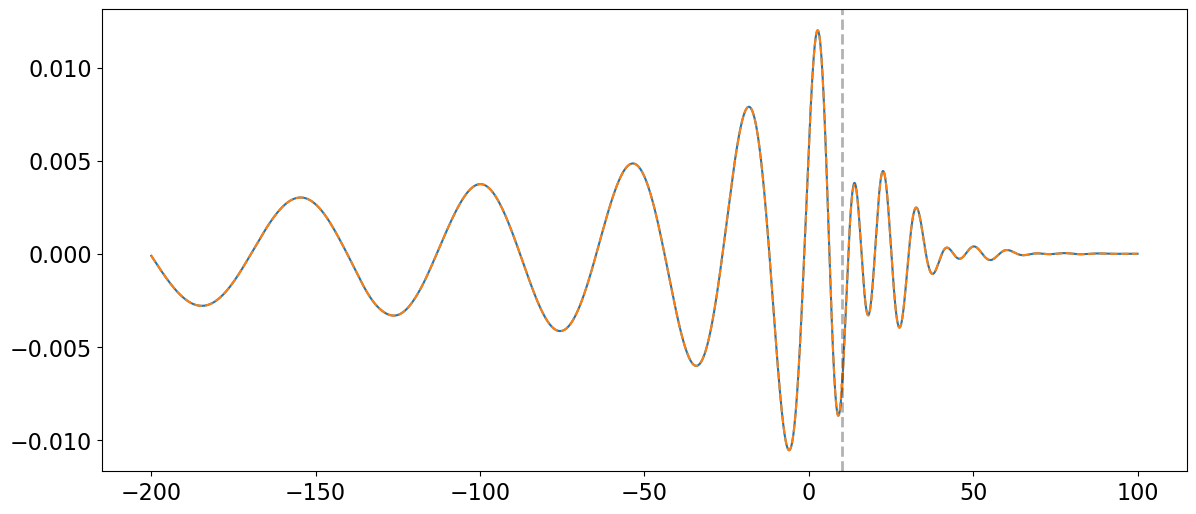

In [287]:
plt.figure(figsize=(14,6))
mask_nr = (nrls[3,2].times > start_time) & (nrls[3,2].times < 100)
plt.plot(nrls[3,2].times[mask_nr], nrls[3,2].strain.real[mask_nr])
plt.plot(x_new, yhat_, ls='--')
plt.axvline(10, c='k', alpha=0.3, lw=2, ls='--')

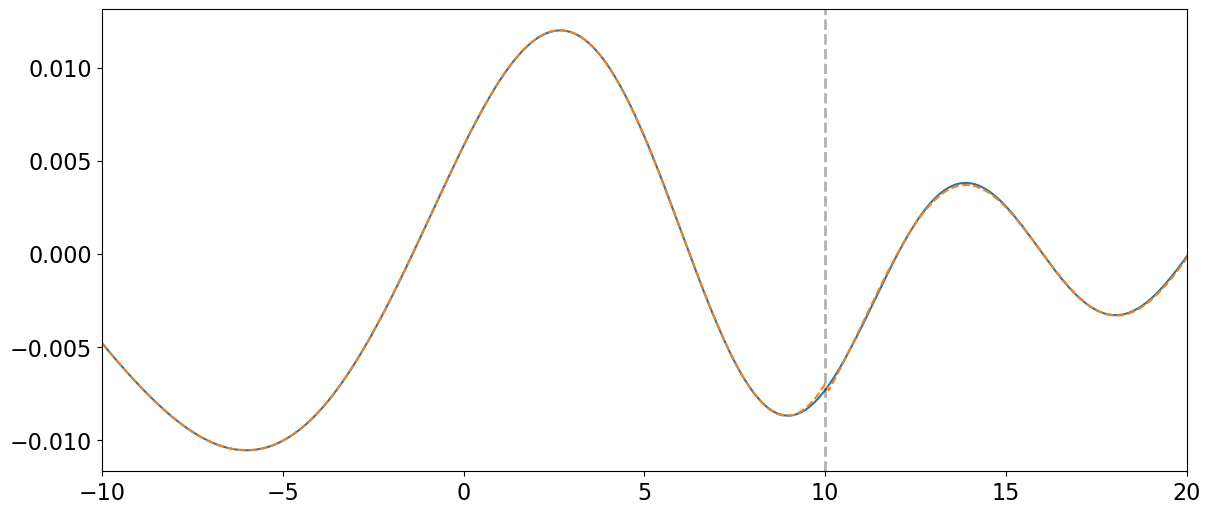

In [288]:
plt.figure(figsize=(14,6))
mask_nr = (nrls[3,2].times > start_time) & (nrls[3,2].times < 100)
plt.plot(nrls[3,2].times[mask_nr], nrls[3,2].strain.real[mask_nr])
plt.plot(x_new, yhat_, ls='--')
plt.xlim(-10, 20)
plt.axvline(10, c='k', alpha=0.3, lw=2, ls='--')